In [1]:
import sys
import scipy
import cv2 as cv
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
from PIL import Image
import skimage as ski
import pytesseract

## Functions

In [2]:
# Helper function to help display an oversized image
def display_image(image, name):
    if image.shape[0] > 1000:
        image = cv.resize(image, (0, 0), fx=0.85, fy=0.85)
    cv.imshow(name, image)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [3]:
# Helper function to sharpen the image
def sharpen(img):
    kernel = np.array([[0, -1, 0],
                        [-1, 5.5, -1],
                        [0, -1, 0]], np.float32)
    img = cv.filter2D(img, -1, kernel)
    return img

In [4]:
# Helper function to increase contrast of an image
def increase_contrast(img):
    lab_img = cv.cvtColor(img, cv.COLOR_RGB2LAB)
    l, a, b = cv.split(lab_img)
    clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    img = cv.merge((cl, a, b))
    img = cv.cvtColor(img, cv.COLOR_LAB2RGB)
    return img

In [5]:
# Helper function to crop the image and eliminate the borders
def crop_image(image, upper, lower, left, right):
    mask = image > 0
    coords = np.argwhere(mask)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    image = image[x0 + upper: x1 + lower, y0 + left: y1 + right]
    return image

In [6]:
# Another helper function to crop and remove the borders
def crop_image_v2(image, tolerance=0):
    mask = image > tolerance
    image = image[np.ix_(mask.any(1), mask.any(0))]
    return image


In [7]:
# Helper function to distinguish different ECG signals on specific image
def separate_components(image):
    ret, labels = cv.connectedComponents(image, connectivity=8)

    # mapping component labels to hue value
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_image = cv.merge([label_hue, blank_ch, blank_ch])
    labeled_image = cv.cvtColor(labeled_image, cv.COLOR_HSV2BGR)

    # set background label to white
    labeled_image[label_hue == 0] = 255
    return labeled_image


In [8]:
# Helper function to display segmented ECG picture
def display_segments(name, item, axis='off'):
    plt.figure(figsize=(12, 9))
    plt.imshow(item, cmap="magma")
    plt.title(name)
    plt.axis(axis)
    plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)
    plt.show()


In [9]:
# Helper function to detect characters
def ocr(image):
    text = pytesseract.image_to_string(image, lang='eng')
    return text

In [10]:
BLOCK_SIZE = 50
THRESHOLD = 25


def preprocess(image):
    image = cv.medianBlur(image, 3)
    image = cv.GaussianBlur(image, (3, 3), 0)
    return (image)

def invert_image(image):
    return (image-255)*255

def postprocess(image):
    #image = cv.medianBlur(image, 3)
    # image = cv2.medianBlur(image, 5)
    # kernel = numpy.ones((3,3), numpy.uint8)
    image = cv.morphologyEx(image, cv.MORPH_OPEN, (5,5),iterations=5)
    return image


def get_block_index(image_shape, yx, block_size): 
    y = np.arange(max(0, yx[0]-block_size), min(image_shape[0], yx[0]+block_size))
    x = np.arange(max(0, yx[1]-block_size), min(image_shape[1], yx[1]+block_size))
    return tuple(np.meshgrid(y, x))


def adaptive_median_threshold(img_in):
    med = np.median(img_in)
    img_out = np.zeros_like(img_in)
    img_out[img_in - med < THRESHOLD] = 255
    return img_out


def block_image_process(image, block_size):
    out_image = np.zeros_like(image)
    for row in range(0, image.shape[0], block_size):
        for col in range(0, image.shape[1], block_size):
            idx = (row, col)
            block_idx = get_block_index(image.shape, idx, block_size)
            out_image[block_idx] = adaptive_median_threshold(image[block_idx])

    return out_image


def process_image_file(filename):
    image_in = cv.cvtColor(cv.imread(filename), cv.COLOR_BGR2GRAY)

    image_in = preprocess(image_in)
    image_out = block_image_process(image_in, BLOCK_SIZE)
    image_out = postprocess(image_out)

    cv.imwrite('bin_' + filename, image_out)

def grid_removal(img):
    kernel = np.ones((10,10),np.uint8)
    dilation = cv.dilate(img,kernel,iterations = 1)
    return dilation
    

## Calculations

An Image scanned in 600 dpi , each point represents 0.042 mm. If one scans an A4 sheet (210 mm x 297 mm ). If you translate in points 
is 5000 X 7071.

## Main Code

### Load Image

(1044, 1235)


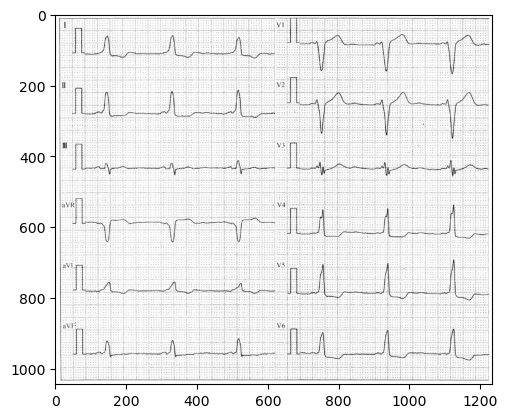

In [11]:
image_name = 'images/test3.jpg'  # select image
    #image_name = 'new/6/22 陆金明 ？/IMAGE_000018.jpg'
image = cv.imread(image_name, flags=cv.IMREAD_GRAYSCALE)  # read the image as GS
#image = cv.imread(image_name).max(axis=-1)
# sanity check
if image is None:
    print('Cannot open image: ' + image_name)
    sys.exit(0)

plt.imshow(image, cmap="gray")
print(image.shape)

### Convert to Binary

(1044, 1235)


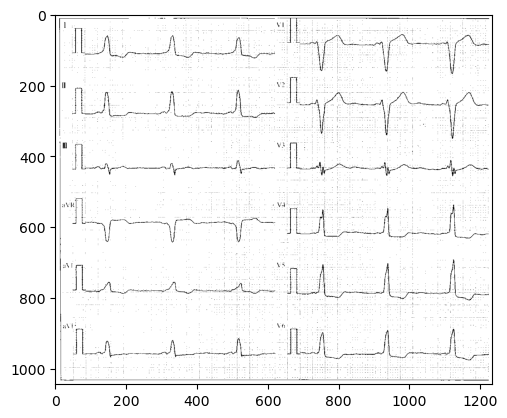

In [12]:
# use thresholding to transform the image into a binary one
ret, th0 = cv.threshold(image, 127, 255,cv.THRESH_BINARY)
plt.imshow(th0, cmap="gray")
print(th0.shape)

(1044, 1235)


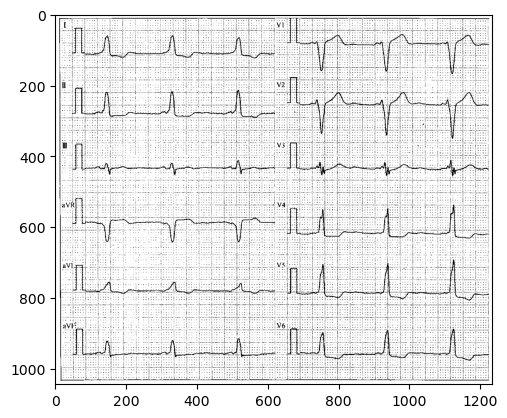

In [13]:
# use thresholding to transform the image into a binary one
ret, th1 = cv.threshold(image, 127, 255,cv.THRESH_OTSU)
plt.imshow(th1, cmap="gray")
print(th1.shape)

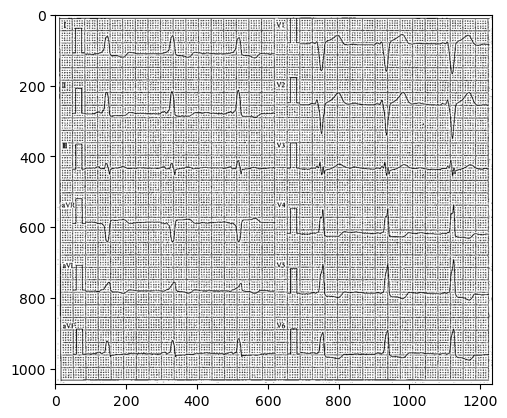

In [14]:
th2 = cv.adaptiveThreshold(image,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
plt.imshow(th2, cmap="gray")

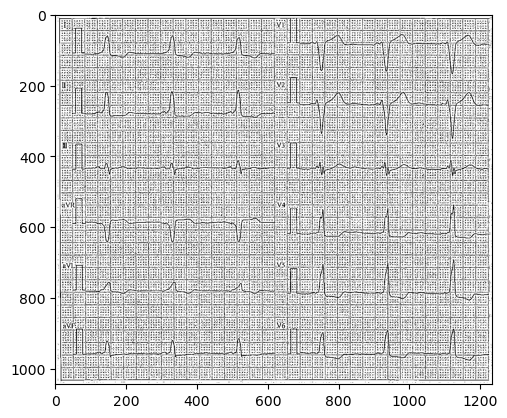

In [15]:
th3 = cv.adaptiveThreshold(image,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
plt.imshow(th3, cmap="gray")

### Image Recognition

Find the largest bouding box that contains the image

In [16]:
def get_rectangular_contours(contours):
    """Approximates provided contours and returns only those which have 4 vertices"""
    res = []
    for contour in contours:
        hull = cv.convexHull(contour)
        peri = cv.arcLength(hull, closed=True)
        approx = cv.approxPolyDP(hull, 0.04 * peri, closed=True)
        if len(approx) == 4:
            res.append(approx)
    return res

In [17]:
foreground  = 255-th1
contours, _ = cv.findContours(foreground, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
rectangular_contours = get_rectangular_contours(contours)

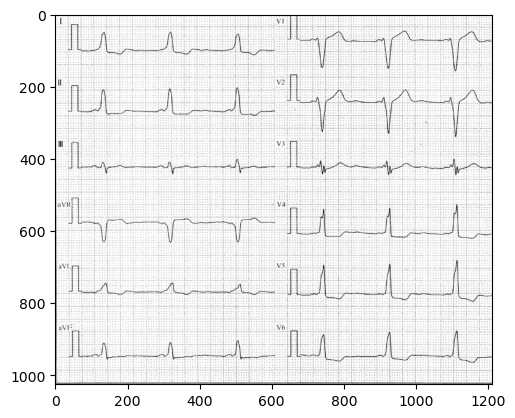

In [18]:
contour_image = image.copy()

# find the biggest countour (c) by the area
c = max(contours, key = cv.contourArea)
x,y,w,h = cv.boundingRect(c)
# draw the biggest contour (c) in green
cv.rectangle(contour_image,(x,y),(x+w,y+h),(0,255,0),2)


plt.imshow(contour_image[y:y+h, x:x+w], cmap="gray")


In [19]:
x, x+w, y,y+h

(12, 1224, 11, 1036)

In [ ]:
#remove the border

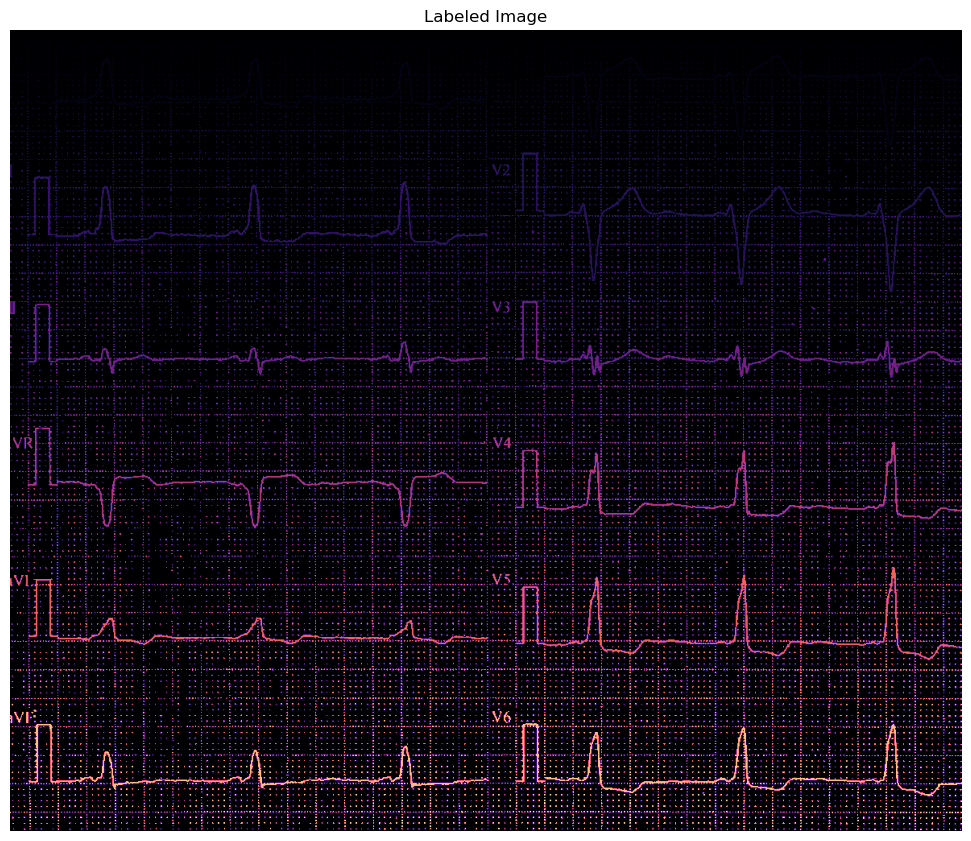

In [20]:
foreground  = 255-th1[y+15:y+h-15, x+15:x+w-15]


structure = np.array([[1, 1, 1],
                      [1, 1, 1],
                      [1, 1, 1]], np.uint8)
labeled_image, nb = ndimage.label(foreground, structure=structure)
display_segments('Labeled Image', labeled_image)

In [55]:
a = np.array([1, 2, 6, 4, 2, 3, 2])
values, counts = np.unique(a, return_counts=True)
values, counts

(array([1, 2, 3, 4, 6]), array([1, 3, 1, 1, 1], dtype=int64))

In [ ]:
u,c = np.unique(labeled_image, return_counts=True) 
#np.argsort(c[1:])[-12:]+1

u,c

(array([    0,     1,     2, ..., 28705, 28706, 28707]),
 array([1069528,      29,       1, ...,       2,       3,       2],
       dtype=int64))

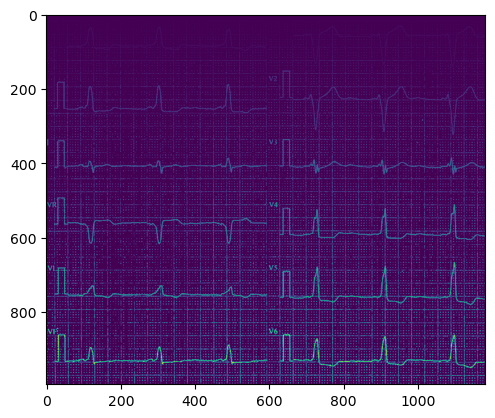

In [23]:
label_im = np.searchsorted(u, labeled_image)
plt.imshow(label_im)

In [ ]:
slice_x, slice_y = ndimage.find_objects(label_im==1099)[0]
slice_x, slice_y

ValueError: not enough values to unpack (expected 2, got 1)

In [31]:
roi = image[34:56, 99:593]

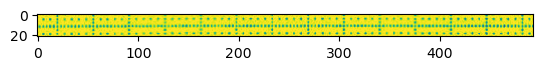

In [32]:
plt.imshow(roi)

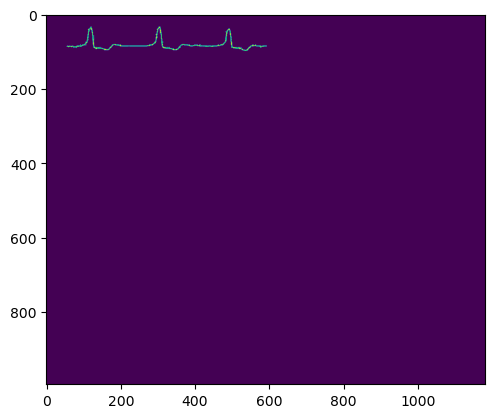

In [30]:
plt.imshow(label_im==1099)

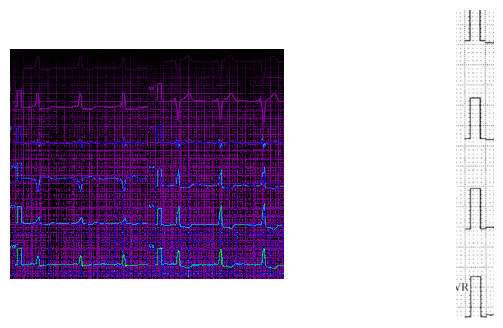

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(label_im, cmap=plt.cm.nipy_spectral)
plt.axis('off')
# custom axes arrguments = plt.axes((left, bottom, width, height), facecolor='w')
plt.subplot(132)
# plt.axes([0, 0, 1, 1])
plt.imshow(roi,cmap="gray")
plt.axis('off')

plt.show()

In [41]:
print()
print('There are ' + str(np.amax(labeled_image) + 1) + ' labeled components.')
print()



There are 28708 labeled components.



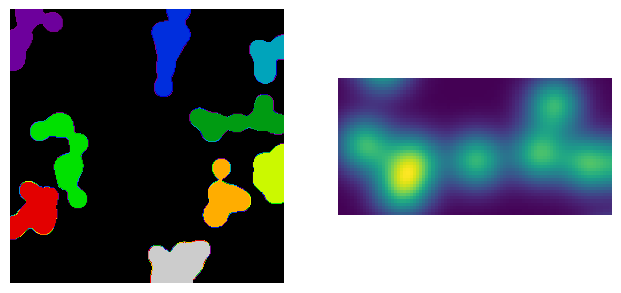

In [74]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

np.random.seed(1)
n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(int), (points[1]).astype(int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))

mask = im > im.mean()

label_im, nb_labels = ndimage.label(mask)

# Find the largest connected component
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
mask_size = sizes < 1000
remove_pixel = mask_size[label_im]
label_im[remove_pixel] = 0
labels = np.unique(label_im)
label_im = np.searchsorted(labels, label_im)
# print('Lable im final values: ',label_im)
# Now that we have only one connected component, extract it's bounding box
'''
# find_objects have syntax: scipy.ndimage.find_objects(input, max_label=0)[source]
1. in which the input have lable more then 0 other wise ignore it
2. Maximum label to be searched for in input. If max_label is not given, the positions of all objects are returned.
3. [0] is provide the range in which the object finds. also when you change 0 to other value it shwos you range error becauase label_im matrix filttered and have all unique value on it.
4. find_obects 1st argument label_im==4 slice the matrix into 2 slices with the range.
5. when you zoom the output you will se the bounding boxes which produced by the find_objects method
'''
# newobj = ndimage.find_objects(label_im==4)[0]
# print(newobj)
# exit()

'''
# For better understanding to find_objects also follow these urls
1. https://stackoverflow.com/questions/36200763/objects-sizes-along-dimension
2. https://www.programcreek.com/python/example/93927/scipy.ndimage.find_objects
3. https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.find_objects.html
'''
slice_x, slice_y = ndimage.find_objects(label_im==4)[0]

# at last roi made a 3D array which show you output in whcih if you zoom. you show the ranged pixcels.
roi = im[slice_x, slice_y]

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(label_im, cmap=plt.cm.nipy_spectral)
plt.axis('off')
# custom axes arrguments = plt.axes((left, bottom, width, height), facecolor='w')
plt.subplot(132)
# plt.axes([0, 0, 1, 1])
plt.imshow(roi)
plt.axis('off')

plt.show()

In [50]:
roi = th1[slice_x,slice_y]

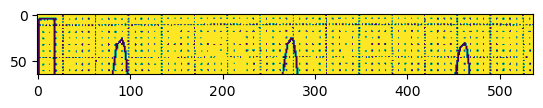

In [51]:
plt.imshow(roi)

### Eliminate Noise using skimage

### Example from SKimage

The skimage version is 0.24.0.


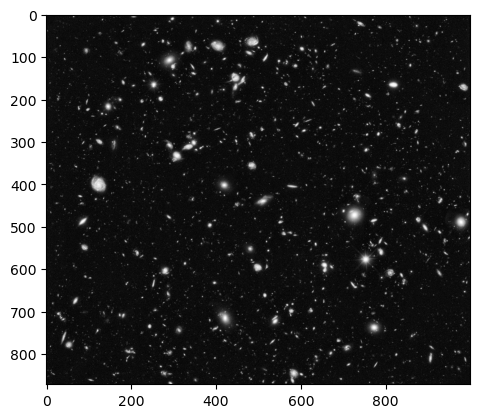

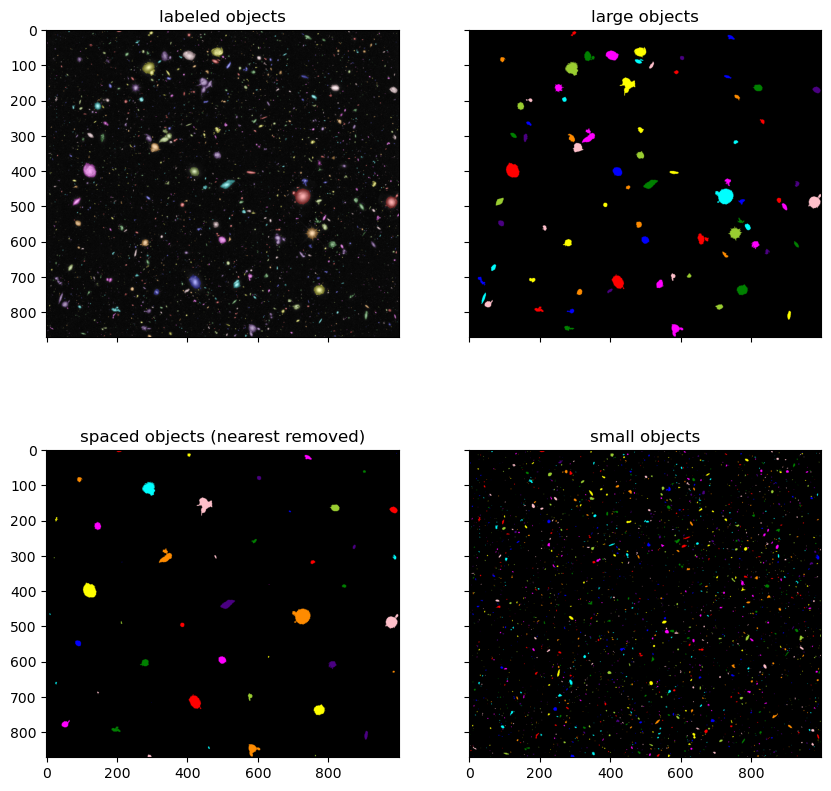

In [24]:
import skimage as ski

print('The skimage version is {}.'.format(ski.__version__))

# Extract foreground by thresholding an image taken by the Hubble Telescope
image = ski.color.rgb2gray(ski.data.hubble_deep_field())
plt.imshow(image, cmap="gray")
foreground = image > ski.filters.threshold_li(image)
objects = ski.measure.label(foreground)

# Separate objects into regions larger and smaller than 100 pixels
large_objects = ski.morphology.remove_small_objects(objects, min_size=100)
small_objects = objects - large_objects

# Remove objects until remaining ones are at least 100 pixels apart.
# By default, larger ones take precedence.
spaced_objects = ski.morphology.remove_objects_by_distance(objects, min_distance=100)

# Plot the results
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].set_title("labeled objects")
ax[0, 0].imshow(ski.color.label2rgb(objects, image=image, bg_label=0))
ax[0, 1].set_title("large objects")
ax[0, 1].imshow(ski.color.label2rgb(large_objects, bg_label=0))
ax[1, 1].set_title("small objects")
ax[1, 1].imshow(ski.color.label2rgb(small_objects, bg_label=0))
ax[1, 0].set_title("spaced objects (nearest removed)")
ax[1, 0].imshow(ski.color.label2rgb(spaced_objects, bg_label=0))
plt.show()

### Applying in the image

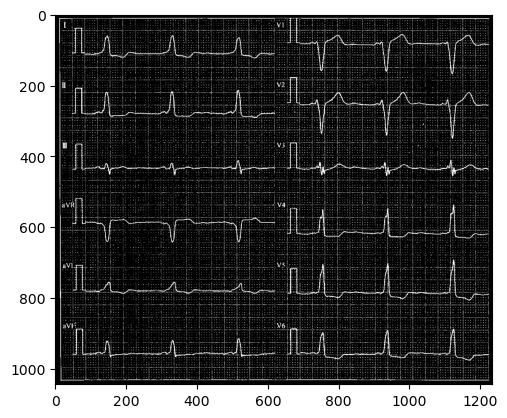

In [37]:
#TODO invert image to obtain the foreground
foreground  = 255-th1
plt.imshow(foreground, cmap="gray")



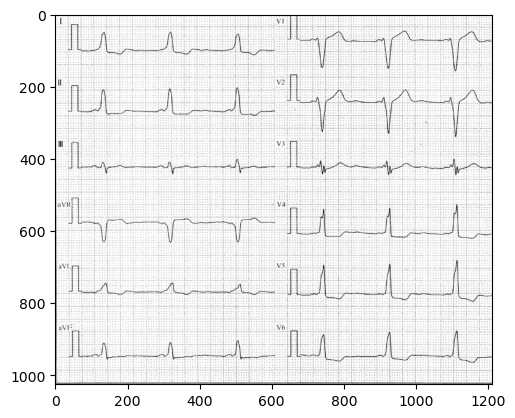

In [39]:
contours, _ = cv.findContours(foreground, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
rectangular_contours = get_rectangular_contours(contours)

contour_image = image.copy()

# find the biggest countour (c) by the area
c = max(contours, key = cv.contourArea)
x,y,w,h = cv.boundingRect(c)
# draw the biggest contour (c) in green
cv.rectangle(contour_image,(x,y),(x+w,y+h),(0,255,0),2)


plt.imshow(contour_image[y:y+h, x:x+w], cmap="gray")

foreground  = 255-th1[y+15:y+h-15, x+15:x+w-15]

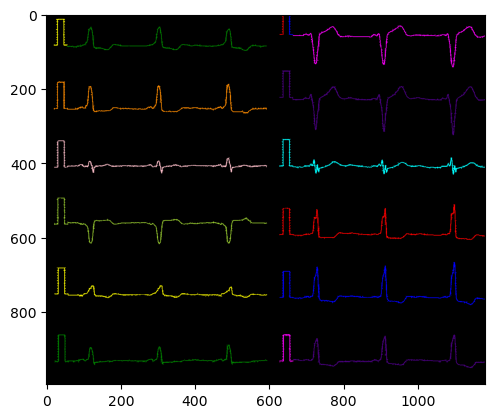

In [40]:
#ret, binary_filtered = cv.threshold(filtered, 30, 255,cv.THRESH_BINARY)
objects = ski.measure.label(foreground)

large_objects = ski.morphology.remove_small_objects(objects, min_size=100)
plt.imshow(ski.color.label2rgb(large_objects,bg_label=0 ), cmap="gray")


The brute force optimal threshold is: 177.5
The computed optimal threshold is: 178.24230227668932


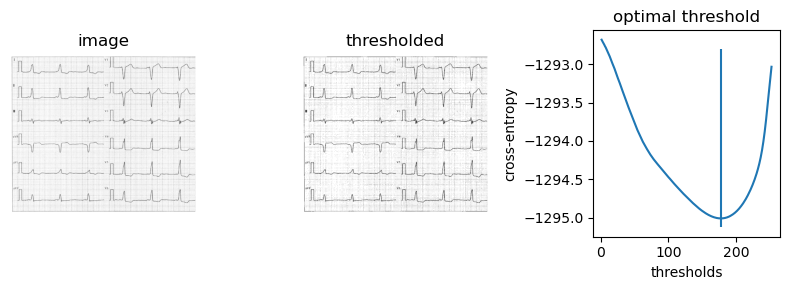

In [36]:
from skimage import filters
from skimage.filters.thresholding import _cross_entropy

thresholds = np.arange(np.min(image) + 1.5, np.max(image) - 1.5)
entropies = [_cross_entropy(image, t) for t in thresholds]

optimal_image_threshold = thresholds[np.argmin(entropies)]

fig, ax = plt.subplots(1, 3, figsize=(8, 3))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('image')
ax[0].set_axis_off()

ax[1].imshow(image > optimal_image_threshold, cmap='gray')
ax[1].set_title('thresholded')
ax[1].set_axis_off()

ax[2].plot(thresholds, entropies)
ax[2].set_xlabel('thresholds')
ax[2].set_ylabel('cross-entropy')
ax[2].vlines(
    optimal_image_threshold,
    ymin=np.min(entropies) - 0.05 * np.ptp(entropies),
    ymax=np.max(entropies) - 0.05 * np.ptp(entropies),
)
ax[2].set_title('optimal threshold')

fig.tight_layout()

print('The brute force optimal threshold is:', optimal_image_threshold)
print('The computed optimal threshold is:', filters.threshold_li(image))

plt.show()



## Remove Grid Lines

The length of  ECG signal would be about 1/3 of the A4 sheet size. 

### Processing Image Blocks

In [21]:
image_in = preprocess(image)
image_in = invert_image(image_in)
display_image(image_in, "Input image")

In [22]:
image_out = block_image_process(image_in, BLOCK_SIZE)
display_image(image_out, "Output image")
image_out = postprocess(image_out) 
display_image(image_out, "Output image")

In [64]:
image_out

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

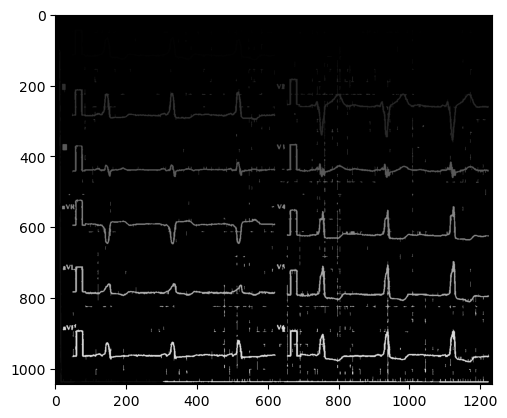

### Template Matching

In [ ]:

image_copy = image[:,:image.shape[1]//2].copy()
template = cv.imread('images/pulse.jpg', cv.IMREAD_GRAYSCALE)
_,new_template = cv.threshold(template,127,255,cv.THRESH_OTSU)
w, h = template.shape[::-1]

res = cv.matchTemplate(image_copy,new_template,cv.TM_CCOEFF_NORMED)
threshold = 0.75
loc = np.where( res >= threshold)
# print(list(zip(*loc[::-1])))
for pt in zip(*loc[::-1]):
    print(pt)
    cv.rectangle(image_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
 
cv.imwrite('res.png',image_copy)
display_image(image_copy, 'Match Template Image')

[(56, 33), (56, 34), (56, 35), (56, 36), (56, 37), (56, 38), (56, 39), (56, 40), (56, 41), (56, 42), (56, 43), (56, 44), (56, 45), (56, 46), (56, 47), (56, 48), (56, 208), (56, 209), (57, 362), (57, 363), (57, 364), (57, 365), (57, 366), (57, 367), (57, 368), (57, 369), (57, 370), (57, 371), (57, 519), (57, 520), (58, 705), (58, 706), (58, 707), (58, 708), (58, 709), (58, 710), (58, 711), (58, 712), (58, 713), (58, 714), (58, 715), (58, 716), (59, 886), (59, 887), (59, 888), (59, 889), (59, 890), (59, 891), (59, 892)]
(56, 33)
(56, 34)
(56, 35)
(56, 36)
(56, 37)
(56, 38)
(56, 39)
(56, 40)
(56, 41)
(56, 42)
(56, 43)
(56, 44)
(56, 45)
(56, 46)
(56, 47)
(56, 48)
(56, 208)
(56, 209)
(57, 362)
(57, 363)
(57, 364)
(57, 365)
(57, 366)
(57, 367)
(57, 368)
(57, 369)
(57, 370)
(57, 371)
(57, 519)
(57, 520)
(58, 705)
(58, 706)
(58, 707)
(58, 708)
(58, 709)
(58, 710)
(58, 711)
(58, 712)
(58, 713)
(58, 714)
(58, 715)
(58, 716)
(59, 886)
(59, 887)
(59, 888)
(59, 889)
(59, 890)
(59, 891)
(59, 892)


In [ ]:
ppts=np.array(list(map(list, zip(*loc[::-1])))) #obtain um array from the list of tuples
ppts_max= ppts[:,0].max()
ppts_min= ppts[:,0].min()
ppts_min,ppts_max

(56, 59)

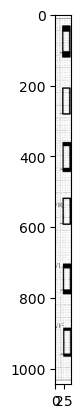

In [95]:
plt.imshow(image_copy[:,ppts_min-w:ppts_max+w], cmap="gray")

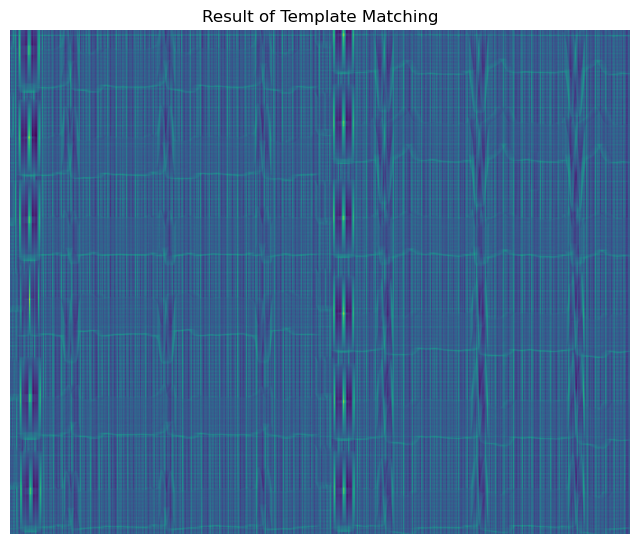

In [56]:
image_copy = image
template = cv.imread('images/pulse.jpg', cv.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]

res = cv.matchTemplate(image_copy[:,20:],template,cv.TM_CCOEFF_NORMED)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(res, cmap='viridis')
ax.set_title("Result of Template Matching")
ax.set_axis_off()
plt.show()

In [41]:
 # Denoise
binary_image_image = cv.fastNlMeansDenoising(binary_image, None, 20, 7, 21) 
display_image(binary_image, 'Binary Image')

## Detect pulse by feature Matching

In [27]:
image_out

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [ ]:
image_copy = image_out
display_image(image_copy, "Copy")
template = cv.imread('images/pulse.jpg', cv.IMREAD_GRAYSCALE)
w, h = template.shape[::-1]

#initiate  ORB detector
orbDetector = cv.ORB_create()

kpt, desct = orbDetector.detectAndCompute(template, None)
kpi, desci = orbDetector.detectAndCompute(image_copy, None)

# Use the Brute force matcher
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck = True)

# Match descriptors.
matches = bf.match(desct,desci)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 25 matches.
reeses_matches = cv.drawMatches(template,kpt,image_copy,kpi,matches[:25],None,flags=2)



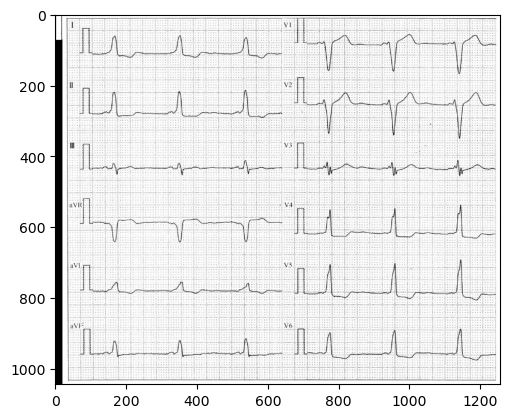

In [26]:
plt.imshow(reeses_matches)